In [21]:
from constants import *
from utility_functions import *
from plot_functions import *
from decoding_approaches import *
from extrapolation_pv_functions import *

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import vonmises, poisson
import math

In [22]:
dropout = True

### Preffered HDs for each neuron

In [23]:
phases = get_evenly_spaced_phases(num_neurons, plot=False, rad=True)

### [OU] Input HDs and HDAVs 

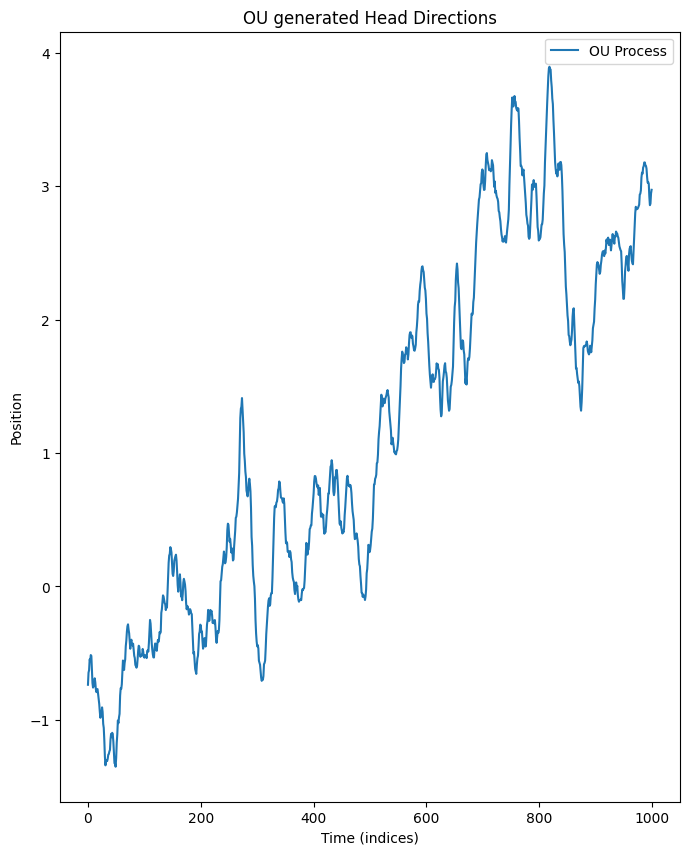

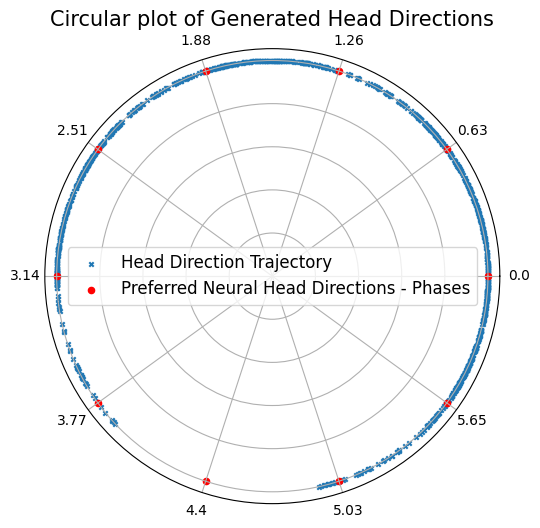

In [24]:
# OU process
x0 = np.random.randn()
v0 = np.random.randn()
positions, velocities = get_OU_inputs(x0, v0, num_positions, dt, tau, mu, sigma)
miliseconds = np.arange(0, T_ms, 10).astype(int)
plt_positions_uncirculated(positions, num_positions, dt, title='OU generated Head Directions')

# Mapping positions on a circle
circ_positions = circular_positions(positions, num_positions)
plt_circulated_pos(circ_positions, phases)


### Von Mises Firing Rates - for neurons

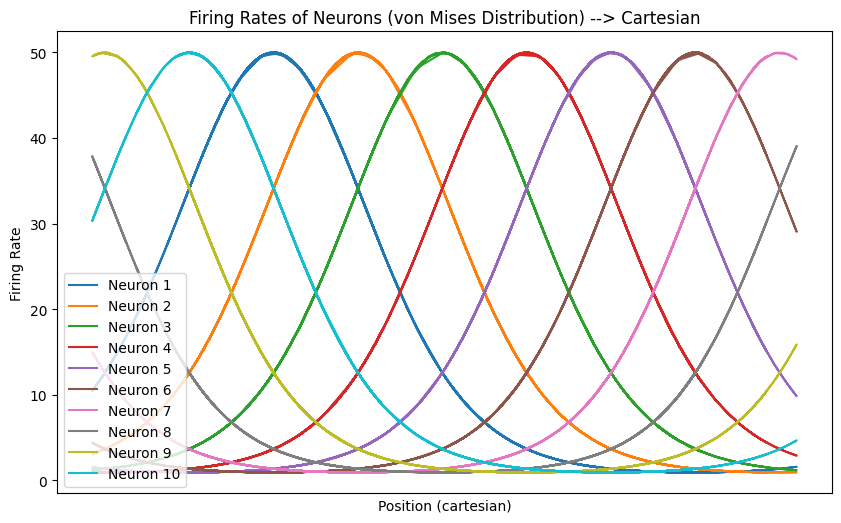

In [25]:
firing_rates_p = np.zeros((num_neurons, num_positions)) # cartesian
firing_rates_cp = np.zeros((num_neurons, num_positions)) # circular

for pos in range(num_positions):
    firing_rates_p[:, pos] = compute_firing_rates_VM(positions[pos], phases)
    firing_rates_cp[:, pos] = compute_firing_rates_VM(circ_positions[pos], phases)


plt_firing_rates_VM(positions, num_neurons, firing_rates_p, num_positions, title='Cartesian')
# plt_firing_rates_VM(circ_positions, num_neurons, firing_rates_cp, num_positions, title='Circluar')

### Generating Observed Poisson Spike Counts

In [26]:
# !! num_positions must be divisible w/ sc_time_step bc of reshaping the original_positions
num_time_windows = math.ceil(num_positions/sc_time_step)
spike_counts = np.zeros((num_time_windows, num_neurons))
decoded_positions = np.zeros(num_time_windows)
final_decodings = np.zeros(num_time_windows)


# --------------------------------------------------------------------
fr_sums = np.zeros((num_time_windows, num_neurons))
tw_original_positions = circ_positions.reshape(num_time_windows, -1)  # this uses circ pos
tw_original_positions_cartesian = positions.reshape(num_time_windows, -1)  # this uses cartesian pos
aggregated_velocities = np.mean(velocities.reshape(-1, sc_time_step), axis=1)  # If sc_time_step != 1

In [27]:
num_time_windows == num_positions

True

In [28]:
for time_window in range(num_time_windows):
    for neuron in range(num_neurons):                                       # sliding through the time windows
        fr_sums[time_window][neuron] = sum(firing_rates_cp[neuron][ time_window*sc_time_step : (time_window+1)*sc_time_step] )
        proba = np.random.random() if dropout else 1
        spike_counts[time_window][neuron] = poisson.rvs(fr_sums[time_window][neuron], sc_time_step) if proba > dropout_proba else 0
        # if spike_counts[time_window][neuron] < 5:
        #     spike_counts[time_window][neuron] = 5 # making sure spike count is >= 5

In [29]:
# np.mean(spike_counts, axis=1)

### Computing posterior distributions: <br>
1) Based on spike counts<br>
2) Based on extrapolation

In [30]:
num_potential_pos = 100
x_values = np.linspace(0, 2*np.pi, num_potential_pos)
final_decodings = np.zeros(num_time_windows)

Initial posteriors

In [31]:
# SC
posterior_sc_0 = compute_posterior_spike_count(spike_counts[0], phases, x_values)
posterior_sc_dt = compute_posterior_spike_count(spike_counts[1], phases, x_values)

In [32]:
# Check if it sums up to ~ 1
sum(posterior_sc_0)

5.404348687491859e-13

In [33]:
# Initial Posterior Extrapolation Distributions (Von Mises) at t = 0 and t = dt
posterior_extr_0 = vonmises.pdf(x_values, kappa, loc=circ_positions[0])
posterior_extr_0 /= (np.sum(posterior_extr_0) + 1e-3)
posterior_extr_dt = vonmises.pdf(x_values, kappa, loc=circ_positions[1])
posterior_extr_dt /= (np.sum(posterior_extr_dt) + 1e-3) 


In [34]:
# Check if it sums up to ~ 1
sum(posterior_extr_dt)

0.9999378945968752

Computing the rest

In [35]:
posterior_sc = np.zeros((num_time_windows, num_potential_pos)) # memory consumption too high; TODO: fix
posterior_sc[:2] = np.array([posterior_sc_0, posterior_sc_dt])
posterior_extr = np.zeros((num_time_windows, num_potential_pos))
posterior_extr[:2] = np.array([posterior_extr_0, posterior_extr_dt])

In [36]:
# Time complexity over the roof; TODO: code smarter
for tw in range(2, num_time_windows):
    posterior_sc[tw] = compute_posterior_spike_count(spike_counts[tw], phases, x_values)
    posterior_extr[tw] = compute_posterior_extrapolation(posterior_extr[tw-1], posterior_extr[tw-2], x_values)
    joint_likelihood = posterior_extr[tw]*posterior_sc[tw]
    final_decodings[tw] = x_values[np.argmax(joint_likelihood)]

In [37]:
cosine_similarity(final_decodings, circ_positions)

0.9058712360400272

### Plot

In [38]:
def PV_plot_trajectory_comparison(real_positions, decoded_positions, num_positions=num_positions, dt = dt, title='Traditional PV approach'):
    plt.figure(figsize=(8, 10))
    time_steps = np.arange(num_positions) * dt
    
    # Plot the real trajectory (OU Process)
    plt.plot(time_steps, real_positions, label='Real Trajectory (OU Process)', color='blue', linewidth=5)

    # Plot the decoded trajectory segment by segment
    for i in range(1, num_positions):
        plt.plot(time_steps[i-1:i+1], decoded_positions[i-1:i+1], color='red', marker='x', markersize = 0.7)

    plt.title(title)
    plt.plot([],[], label='Decoded trajectory', color='red')
    # plt.plot([],[], " ", label=f'MSE = {mse:.3f}')
    dropout_ind = "With" if dropout == True else "Without"
    plt.plot([],[], " ", label=f'{dropout_ind} Dropouts')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (Cartesian)')
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.show()

In [39]:
print(positions[55:60])
print(np.unwrap(final_decodings[55:60]))


[-0.98225229 -0.9560361  -0.81863109 -0.76322643 -0.76903386]
[5.83891968 5.77545316 5.58505361 5.71198664 5.71198664]


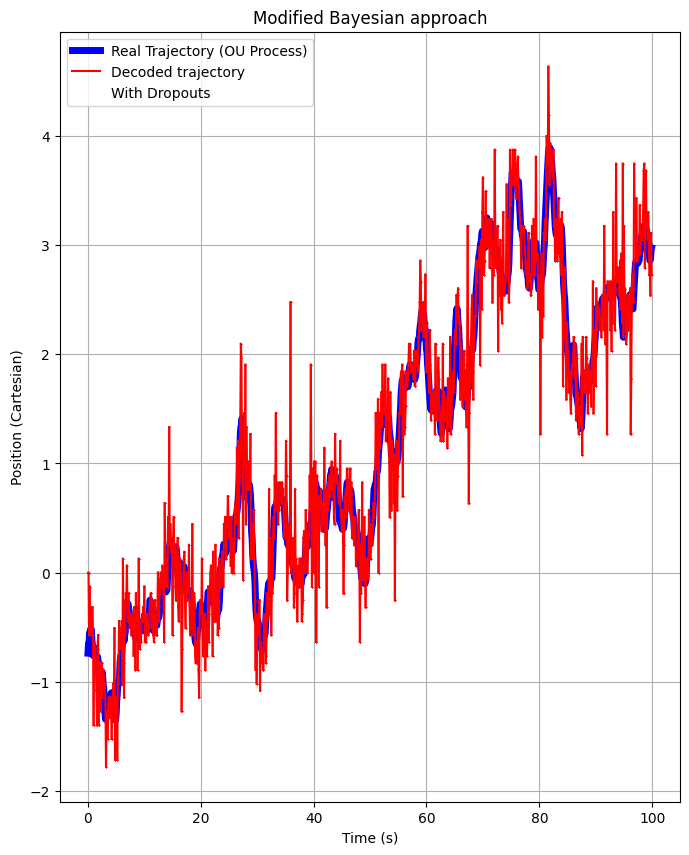

In [40]:
PV_plot_trajectory_comparison(positions, np.unwrap(final_decodings), title='Modified Bayesian approach')

### Problem: I don't get pdfs for spike counts posterior ??<br>
they should sum up to ~ 1